# 5. EOF Analysis

Reproduce methodology from Takahashi et al · 2011 - ENSO regimes: Reinterpreting the canonical and Modoki El Niño 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
import os
import pandas as pd
import xarray as xr
import calendar
import scipy.stats

from pandas.plotting import lag_plot
from datetime import datetime

import sklearn
from sklearn.decomposition import PCA

from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
CMIP6_FOLDER = 'datasets/CMIP6/CMIP6_regridded/w_cellarea'
HadISST_FOLDER = 'datasets/HadISST/HadISST_regridded/regridded'
GODAS_FOLDER = 'datasets/GODAS/GODAS_regridded'

In [3]:
CMIP6_ANOM_1M_FOLDER = 'datasets/CMIP6/CMIP6_regridded/anom_1m'
HadISST_ANOM_1M_FOLDER = 'datasets/HadISST/HadISST_regridded/anom_1m'
GODAS_ANOM_1M_FOLDER = 'datasets/GODAS/GODAS_regridded/anom_1m'

In [4]:
CMIP6_EC_FOLDER = 'datasets/CMIP6/CMIP6_regridded/ec_indices'
HadISST_EC_FOLDER = 'datasets/HadISST/HadISST_regridded/ec_indices'
GODAS_EC_FOLDER = 'datasets/GODAS/GODAS_regridded/ec_indices'

In [5]:
!ls {HadISST_ANOM_1M_FOLDER}

OBS.HAD.HADISST.regridded_tos_anom_1m.nc


### Global variables

In [6]:
MIN_LAT, MAX_LAT = -10,10
# MIN_LAT, MAX_LAT = -50,50
MIN_LON, MAX_LON = 100,300
time_sel = '1950-01-16'

# START_YEAR = '1870'
# END_YEAR = '2010'

START_YEAR = '1850'
END_YEAR = '2024'

start_date = pd.to_datetime(START_YEAR)
end_date = pd.to_datetime(END_YEAR)

# climatology base period
BASE_PERIOD_START = '1961-01-01'
BASE_PERIOD_END = '1990-12-31'
display(BASE_PERIOD_START, BASE_PERIOD_END)

BASE_PERIOD_START_yr = BASE_PERIOD_START.split("-")[0]
BASE_PERIOD_END_yr = BASE_PERIOD_END.split("-")[0]
display(BASE_PERIOD_START_yr, BASE_PERIOD_END_yr)

'1961-01-01'

'1990-12-31'

'1961'

'1990'

In [7]:
IMG_FOLDER = "img/5_EOF_analysis/"
os.makedirs(IMG_FOLDER, exist_ok=True) 

SAVE_PLOTS_TO_DISK = True

## Define functions

#### `find_file`

In [8]:
def find_file(directory, source_id):
    filenames = os.listdir(directory)

    # Iterate over files int the directory and return the first match
    for filename in filenames:
        if source_id in filename:
            filepath = os.path.join(directory, filename)
            return filename, filepath
    print(f"No file with source id {source_id} was found")
    return None 

## Load CMIP6 model outputs

In [9]:
# # create dictionary for reggridded data
# cmip_dict = dict()

# print("Loading following regridded CMIP6 datasets from disk:\n")
# for filename in os.listdir(CMIP6_FOLDER):
#     filepath = os.path.join(CMIP6_FOLDER, filename)

#     # if file exist on disk, load it
#     if os.path.isfile(filepath):
#         print(f"• {filename}")
#         cmip_dict[filename] = xr.open_dataset(filepath)

In [10]:
# for key in sorted(cmip_dict.keys()):
#     print(f"{key}")
#     ds = cmip_dict[key]    
#     print(f"•  Institution: {ds.attrs['institution']}")
#     print(f"•  Creation date: {ds.attrs['creation_date'].split("T")[0]}")
#     print(f"•  Time: From {ds['time'][0].values.astype('datetime64[D]')} to {ds['time'][-1].values.astype('datetime64[D]')}")
#     print(f"•  Dimensions: {dict(ds.sizes)}")
#     print(f"•  {ds.data_vars}")
#     print()
#     # display(ds)

## Load HadISST
To test the model performance, the Hadley Centre Sea Ice and Sea Surface Temperature data set (HadISST) _(TODO: replace with Global Ocean Data Assimilation System (GODAS) reanalysis)_ was used for theperiod 1990–2022 as we take these values to be our ground truth. We leave a 5-year gap between the training/validation period and the testing period to avoid any impact of oceanic memory, similarly to ref. 37 . Anomalieswere computed for all the variables used in this study and were coarsened to a 5◦ × 5◦ resolution in order toimprove model performance by enhancing the spatial signature of major features.
??????



#### Load data from Hadley Centre Sea Ice and Sea Surface Temperature data set (HadISST)

In [11]:
new_filename = "OBS.HAD.HADISST.regridded.nc"
filepath = os.path.join(HadISST_FOLDER, new_filename)

if os.path.isfile(filepath):
    print(f"{new_filename} already exist in {HadISST_FOLDER}. Loading it from disk...\n")
    hadisst_ds_regrid = xr.open_dataset(filepath)
else:
    print(f"{new_filename} doesnt exist...\n")

OBS.HAD.HADISST.regridded.nc already exist in datasets/HadISST/HadISST_regridded/regridded. Loading it from disk...



### EDA

In [12]:
print(f"•  Institution: {hadisst_ds_regrid.attrs['institution']}")
# print(f"•  Creation date: {hadisst_ds.attrs['creation_date'].split("T")[0]}")
print(f"•  Time: From {hadisst_ds_regrid['time'][0].values.astype('datetime64[D]')} to {hadisst_ds_regrid['time'][-1].values.astype('datetime64[D]')}")
print(f"•  Dimensions: {dict(hadisst_ds_regrid.sizes)}")
print(f"•  {hadisst_ds_regrid.data_vars}")
print()

•  Institution: Met Office Hadley Centre
•  Time: From 1870-01-16 to 2024-02-15
•  Dimensions: {'time': 1850, 'lat': 180, 'lon': 360}
•  Data variables:
    tos      (time, lat, lon) float32 480MB ...



In [13]:
# replace masked values (-1000) with nan
hadisst_ds_regrid['tos'] = hadisst_ds_regrid['tos'].where(hadisst_ds_regrid['tos'] != -1000, np.nan)

#### Map SST in the whole globe

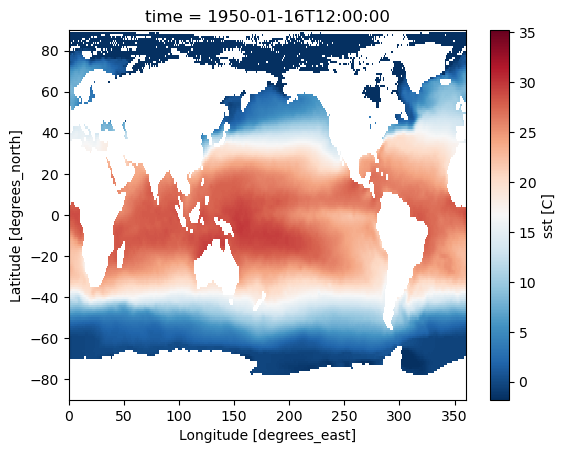

In [14]:
hadisst_ds_regrid['tos'].sel(
    time=time_sel
).plot(vmin=hadisst_ds_regrid['tos'].min(), vmax=hadisst_ds_regrid['tos'].max(), cmap='RdBu_r')
plt.show()

#### Map SST in the pacific

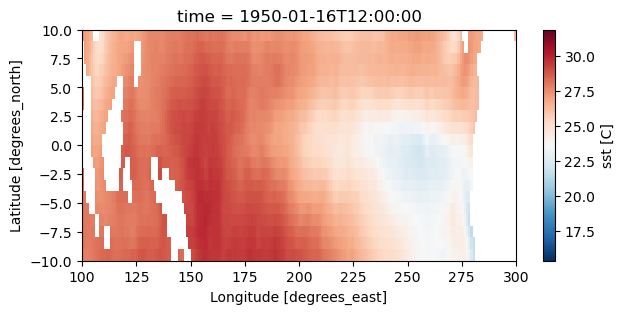

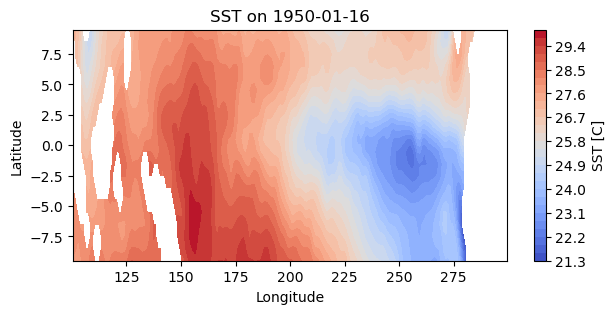

In [15]:
# restric coordinates to the pacific 
pacific_sst = hadisst_ds_regrid['tos'].sel(
    lat=slice(MIN_LAT, MAX_LAT),
    lon=slice(MIN_LON, MAX_LON)
)

plt.figure(figsize=(7, 3))
pacific_sst.sel(time=time_sel).plot(vmin=pacific_sst.min(), vmax=pacific_sst.max(), cmap='RdBu_r')
plt.show()

# define 20 levels for contour map so that the color bar is symetrical
# contour_levels = np.linspace(-max_abs_value, max_abs_value, 21)  

# Plot SSTs using contours
plt.figure(figsize=(7, 3))
im = plt.contourf(pacific_sst['lon'], pacific_sst['lat'], pacific_sst.sel(time=time_sel).values.squeeze(), 
             cmap='coolwarm', levels=30)

plt.colorbar(label='SST [C]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'SST on {time_sel}')
plt.show()


## Plot the first mode of SSTs

EOF are a way of identifying the modes of variability of a system. 
When we talk about the Modes of variability of the Pacific Ocean, we have to think about this ocean that has an irregular shape, and is also beeing acted on by forces such as wind stress, that affect the modes of variability. But nonetheless, you'll still have fundamenatal patterns where parts of the water tend to behave in unison with other partss of the water around it.
**EOFs are all about exploring those patterns and trying to understand what happens at one place and how does it affect what happens around it, and so forth.**

_(Source: Chad Green - [The Climate Data Toolbox for MATLAB - El Niño and Empirical Orthogonal Functions](https://youtu.be/A5UjLO-67GQ?feature=shared))_.


Plot the main (1st) mode of variability of SSTs from 1950 to 2016

In [16]:
# reshape back to the original 3D array: (time_steps, lat, lon)
# pacific_sst_slice_3d = pacific_sst_slice_2d.reshape(n_time_steps, n_lat, n_lon)
# print("pacific_sst_slice_3d.shape: ", pacific_sst_slice_3d.shape)

pacific_sst_slice.shape:  (1848, 20, 200)
• n_time_steps:  1848
• n_lat:  20
• n_lon:  200
land_mask.shape:  (20, 200)
pacific_sst_slice_2d.shape:  (1848, 4000)
projected_data.shape:  (1848, 2)
pca.components_.shape:  (2, 4000)
first_loading.shape:  (4000,)
first_loading_reshaped.shape:  (20, 200)
max_abs_value:  0.05520901


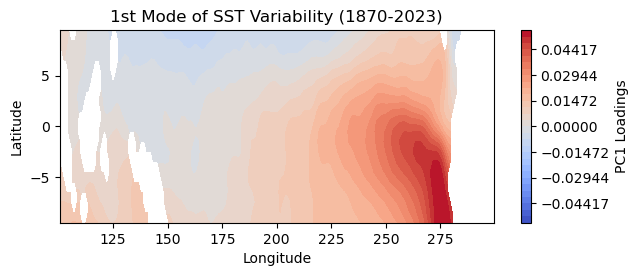

In [17]:
#### SST VALUES ####
plt.figure(figsize=(7, 2.5))

# Squeeze out dimensions of size one, if any (e.g. member_id, dcpp_init_year)
squeezed_ds = pacific_sst.squeeze()

# select ssts for the required time period
pacific_sst_slice = pacific_sst.sel(time=slice(start_date, end_date))
print('pacific_sst_slice.shape: ', pacific_sst_slice.shape)


# Get the number of time steps, and latitude and longitude dimensions
n_time_steps = pacific_sst_slice.coords['time'].size
n_lat = pacific_sst_slice.coords['lat'].size
n_lon = pacific_sst_slice.coords['lon'].size
print('• n_time_steps: ', n_time_steps)
print('• n_lat: ', n_lat)
print('• n_lon: ', n_lon)

# Create a land mask where True indicates land and False indicates ocean
land_mask = np.isnan(pacific_sst_slice[0].values)
print("land_mask.shape: ", land_mask.shape)

# Replace NaN values with 0
pacific_sst_slice = pacific_sst_slice.fillna(0)

# reshape sst_anom into a 2D array: (time_steps, lat * lon)
pacific_sst_slice_2d = pacific_sst_slice.values.reshape(n_time_steps, -1)
print("pacific_sst_slice_2d.shape: ", pacific_sst_slice_2d.shape)


# Project to a new array of shape (n_samples, n_components)
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(pacific_sst_slice_2d)
projected_data = pca.transform(pacific_sst_slice_2d)

# (n_samples, n_components) = (792, 2)
print("projected_data.shape: ", projected_data.shape)

# (n_components, n_features) = (2, 20000).
print("pca.components_.shape: ", pca.components_.shape)

 # Extract the first principal component
first_loading = pca.components_[0]
print("first_loading.shape: ", first_loading.shape)

# Reshape the first principal component back to the original spatial dimensions
first_loading_reshaped = first_loading.reshape(n_lat, n_lon)
print("first_loading_reshaped.shape: ", first_loading_reshaped.shape)


max_abs_value = max(abs(np.min(first_loading_reshaped)), abs(np.max(first_loading_reshaped)))
print("max_abs_value: ", max_abs_value)

# define 20 levels for contour map so that the color bar is symetrical
countour_levels = np.linspace(-max_abs_value, max_abs_value, 31)  


# Apply the land mask to the first mode
first_loading_reshaped[land_mask] = np.nan

# # Plot the first mode of variability
# plt.figure(figsize=(10, 6))
im = plt.contourf(pacific_sst['lon'], pacific_sst['lat'], first_loading_reshaped, 
             cmap='coolwarm', levels=countour_levels, vmin=-max_abs_value, vmax=max_abs_value)

plt.colorbar(label='PC1 Loadings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

start_year = pacific_sst_slice['time'][0].values.astype('datetime64[Y]')
end_year = pacific_sst_slice['time'][-1].values.astype('datetime64[Y]')

plt.title(f'1st Mode of SST Variability ({start_year}-{end_year})')
plt.show()

Interpretation of the First Principal Component (Chat GPT)

- High Values on the map:
    - Regions with high absolute values (positive or negative) in the first principal component map contribute significantly to the overall variance captured by this component.
    - High positive values might indicate regions that tend to increase together, while high negative values might indicate regions that tend to decrease together or vary inversely with regions of positive values.
- Low Values on the map:
    - Regions with values close to zero in the first principal component map contribute less to this specific mode of variability.



## Deseasonalize the entire field of SSTs

In [18]:
# apply seasonal decomposition to the time series of each grid cell and extract the deseasonalized component 
def deseasonalize(grid_cell_timeseries):
    if np.sum(np.isnan(grid_cell_timeseries)) > 0:  
        return grid_cell_timeseries
    else:
        decomposition = seasonal_decompose(grid_cell_timeseries, model='additive', period=12)
        deseasonalized = grid_cell_timeseries - decomposition.seasonal
        return deseasonalized


# apply seasonal decomposition to the time series of each grid cell and extract the deseasonalized component 
def detrend(grid_cell_timeseries):
    if np.sum(np.isnan(grid_cell_timeseries)) > 0:  
        return grid_cell_timeseries
    else:
        decomposition = seasonal_decompose(grid_cell_timeseries, model='additive', period=12)
        detrended = grid_cell_timeseries - decomposition.trend
        return detrended


# Apply the deseasonalization function across all lat and lon grid cells
deseasonalized_sst = xr.apply_ufunc(
    deseasonalize,
    hadisst_ds_regrid['tos'],
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[hadisst_ds_regrid['tos'].dtype]
)


# Apply the detrended function across all lat and lon grid cells
detrended_sst = xr.apply_ufunc(
    detrend,
    hadisst_ds_regrid['tos'],
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[hadisst_ds_regrid['tos'].dtype]
)

# Make sure to load the data if using Dask arrays
deseasonalized_sst = deseasonalized_sst.compute()
detrended_sst = detrended_sst.compute()

# Add the deseasonalized/detrended SST as a new variable in the original dataset
hadisst_ds_regrid['tos_deseason'] = deseasonalized_sst.transpose('time', 'lat', 'lon')
hadisst_ds_regrid['tos_detrend'] = detrended_sst.transpose('time', 'lat', 'lon')


### Plot SSTs and Deseasonalized SSTs the pacific area

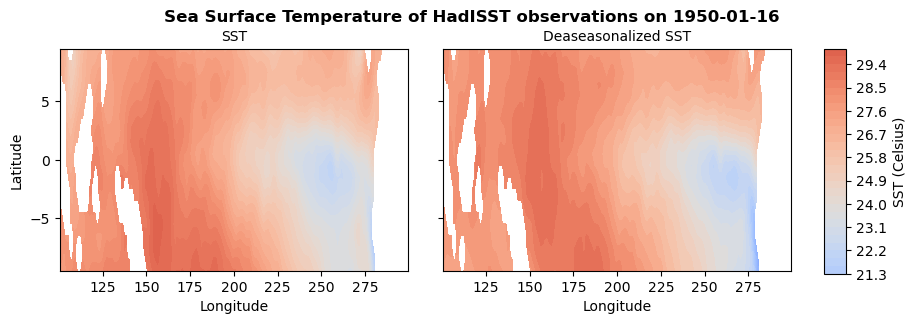

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 3), sharex=True, sharey=True)

# slice the datasets on selected areas
pacific_sst = hadisst_ds_regrid['tos'].sel(lat=slice(MIN_LAT, MAX_LAT), lon=slice(MIN_LON, MAX_LON))
pacific_deseasoned_sst = hadisst_ds_regrid['tos_deseason'].sel(lat=slice(MIN_LAT, MAX_LAT), lon=slice(MIN_LON, MAX_LON))

# calculate min and max sst values to align colors for both plots
min_value = min(np.min(pacific_sst), np.min(pacific_deseasoned_sst)).item()
max_value = max(np.max(pacific_sst), np.max(pacific_deseasoned_sst)).item()

im1 = ax1.contourf(pacific_sst['lon'], pacific_sst['lat'], 
                   pacific_sst.sel(time=time_sel).values.squeeze(), 
                   vmin=min_value, vmax=max_value, cmap='coolwarm', levels=30)
ax1.set_title('SST', fontsize=10)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

im2 = ax2.contourf(pacific_deseasoned_sst['lon'], pacific_deseasoned_sst['lat'],
                   pacific_deseasoned_sst.sel(time=time_sel).values.squeeze(), 
                   vmin=min_value, vmax=max_value, cmap='coolwarm', levels=30)
ax2.set_title(f'Deaseasonalized SST', fontsize=10)
ax2.set_xlabel('Longitude')
# ax2.set_ylabel('Latitude')

fig.suptitle(f"Sea Surface Temperature of HadISST observations on {time_sel}", fontweight="bold")

# Create a shared colorbar for the entire figure
fig.subplots_adjust(right=0.79, top=0.85, wspace=0.1) # Adjust spacing between subplots, as well as right margin for the colorbar
cbar_ax = fig.add_axes(rect=[0.82, 0.10, 0.02, 0.75]) # rect=(left, bottom, right, top), default: (0, 0, 1, 1)
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label('SST (Celsius)')
plt.show()

In [20]:
# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 4), sharex=True, sharey=True)

# # slice the datasets on selected areas
# pacific_detrended_sst = hadisst_ds_regrid['tos_detrend'].sel(lat=slice(MIN_LAT, MAX_LAT), lon=slice(MIN_LON, MAX_LON))

# im1 = ax1.contourf(pacific_detrended_sst['lon'], pacific_detrended_sst['lat'], 
#                    pacific_detrended_sst.sel(time=time_sel).values.squeeze(), 
#                    cmap='coolwarm', levels=30)
# ax1.set_title('Detrended SSTs', fontsize=10)
# ax1.set_xlabel('Longitude')
# ax1.set_ylabel('Latitude')

# fig.suptitle(f"Sea Surface Temperature of HadISST observations on {time_sel}", fontweight="bold")

# # Create a shared colorbar for the entire figure
# fig.subplots_adjust(right=0.79, top=0.85, wspace=0.1) # Adjust spacing between subplots, as well as right margin for the colorbar
# cbar_ax = fig.add_axes(rect=[0.82, 0.10, 0.02, 0.75]) # rect=(left, bottom, right, top), default: (0, 0, 1, 1)
# cbar = fig.colorbar(im1, cax=cbar_ax)
# cbar.set_label('SST (Celsius)')
# plt.show()

### Plot the first mode of Deseasonalized SSTs

EOF are a way of identifying the modes of variability of a system. 
When we talk about the Modes of variability of the Pacific Ocean, we have to think about this ocean that has an irregular shape, and is also beeing acted on by forces such as wind stress, that affect the modes of variability. But nonetheless, you'll still have fundamenatal patterns where parts of the water tend to behave in unison with other partss of the water around it.
**EOFs are all about exploring those patterns and trying to understand what happens at one place and how does it affect what happens around it, and so forth.**

_(Source: Chad Green - [The Climate Data Toolbox for MATLAB - El Niño and Empirical Orthogonal Functions](https://youtu.be/A5UjLO-67GQ?feature=shared))_.


Plot the main (1st) mode of variability of SSTs from 1950 to 2016

pacific_deseasoned_sst_slice.shape:  (1848, 20, 200)
• n_time_steps:  1848
• n_lat:  20
• n_lon:  200
land_mask.shape:  (20, 200)
pacific_deseasoned_sst_slice_2d.shape:  (1848, 4000)
projected_data.shape:  (1848, 2)
pca.components_.shape:  (2, 4000)
first_loading.shape:  (4000,)
first_loading_reshaped.shape:  (20, 200)
0.03572315


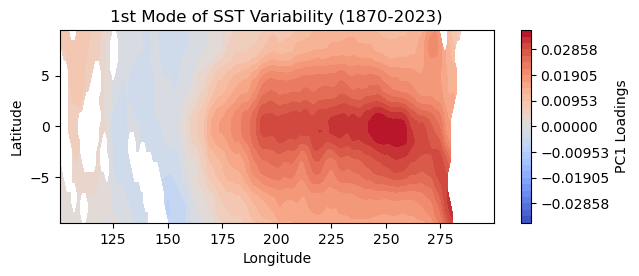

In [21]:
#### DESEASONED SST VALUES ####
# select ssts for the required time period
pacific_deseasoned_sst_slice = pacific_deseasoned_sst.sel(time=slice(start_date, end_date))
print('pacific_deseasoned_sst_slice.shape: ', pacific_deseasoned_sst_slice.shape)

# Get the number of time steps, and latitude and longitude dimensions
n_time_steps = pacific_deseasoned_sst_slice.coords['time'].size
n_lat = pacific_deseasoned_sst_slice.coords['lat'].size
n_lon = pacific_deseasoned_sst_slice.coords['lon'].size
print('• n_time_steps: ', n_time_steps)
print('• n_lat: ', n_lat)
print('• n_lon: ', n_lon)

# Create a land mask where True indicates land and False indicates ocean
land_mask = np.isnan(pacific_deseasoned_sst_slice[0].values)
print("land_mask.shape: ", land_mask.shape)

# Replace NaN values with 0
pacific_deseasoned_sst_slice = pacific_deseasoned_sst_slice.fillna(0)

# reshape sst_anom into a 2D array: (time_steps, lat * lon)
pacific_deseasoned_sst_slice_2d = pacific_deseasoned_sst_slice.values.reshape(n_time_steps, -1)
print("pacific_deseasoned_sst_slice_2d.shape: ", pacific_deseasoned_sst_slice_2d.shape)


# Project to a new array of shape (n_samples, n_components)
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(pacific_deseasoned_sst_slice_2d)
projected_data = pca.transform(pacific_deseasoned_sst_slice_2d)

# (n_samples, n_components) = (792, 2)
print("projected_data.shape: ", projected_data.shape)

# (n_components, n_features) = (2, 20000).
print("pca.components_.shape: ", pca.components_.shape)

 # Extract the first principal component
first_loading = pca.components_[0]
print("first_loading.shape: ", first_loading.shape)

# Reshape the first principal component back to the original spatial dimensions
first_loading_reshaped = first_loading.reshape(n_lat, n_lon)
print("first_loading_reshaped.shape: ", first_loading_reshaped.shape)


max_abs_value = max(abs(np.min(first_loading_reshaped)), abs(np.max(first_loading_reshaped)))
print(max_abs_value)

# define 20 levels for contour map so that the color bar is symetrical
countour_levels = np.linspace(-max_abs_value, max_abs_value, 31)  


# Apply the land mask to the first mode
first_loading_reshaped[land_mask] = np.nan

# # Plot the first mode of variability
plt.figure(figsize=(7, 2.5))

im = plt.contourf(pacific_deseasoned_sst['lon'], pacific_deseasoned_sst['lat'], first_loading_reshaped, 
             cmap='coolwarm', levels=countour_levels, vmin=-max_abs_value, vmax=max_abs_value)

plt.colorbar(label='PC1 Loadings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

start_year = pacific_deseasoned_sst_slice['time'][0].values.astype('datetime64[Y]')
end_year = pacific_deseasoned_sst_slice['time'][-1].values.astype('datetime64[Y]')

plt.title(f'1st Mode of SST Variability ({start_year}-{end_year})')
plt.show()

## Load HadISST anomalies

In [22]:
filename, filepath = find_file(HadISST_ANOM_1M_FOLDER, "HADISST")
filepath

'datasets/HadISST/HadISST_regridded/anom_1m/OBS.HAD.HADISST.regridded_tos_anom_1m.nc'

In [23]:
hadisst_anom_1m_ds = xr.open_dataset(filepath)

# Squeeze out dimensions of size one, if any (e.g. member_id, dcpp_init_year)
hadisst_anom_1m_squeezed_ds = hadisst_anom_1m_ds.squeeze()

### Calculate the first two EOF modes of SST anomalies

In [24]:
# print(f"•  Time: From {hadisst_sst_anom_slice['time'][0].values.astype('datetime64[D]')} to {hadisst_sst_anom_slice['time'][-1].values.astype('datetime64[D]')}")


In [25]:
hadisst_sst_anom_slice = hadisst_anom_1m_squeezed_ds["tos_anom_1m"].sel(time=slice(start_date, end_date),
                                                                        lat=slice(MIN_LAT, MAX_LAT),
                                                                        lon=slice(MIN_LON, MAX_LON))

# Get the number of time steps, and latitude and longitude dimensions
n_time_steps = hadisst_sst_anom_slice.coords['time'].size
n_lat = hadisst_sst_anom_slice.coords['lat'].size
n_lon = hadisst_sst_anom_slice.coords['lon'].size

# Create a land mask where True indicates land and False indicates ocean
land_mask = np.isnan(hadisst_sst_anom_slice[0].values)

# Replace NaN values with 0
hadisst_sst_anom_slice = hadisst_sst_anom_slice.fillna(0)

# reshape sst_anom into a 2D array: (time_steps, lat * lon)
hadisst_sst_anom_slice_2d = hadisst_sst_anom_slice.values.reshape(n_time_steps, -1)

# Project to a new array of shape (n_samples, n_components)
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(hadisst_sst_anom_slice_2d)
projected_data = pca.transform(hadisst_sst_anom_slice_2d)

# convert to a dataframe
pca_scores = pd.DataFrame(projected_data, columns=['PC1', 'PC2'])

# replace numerical index with datetime
pca_scores.index = pd.to_datetime(hadisst_sst_anom_slice['time'].values)


### Plot the first two EOF modes of SST anomalies

`components_`: ndarray of shape (n_components, n_features)\
Principal axes (Loadings) in feature space, representing the directions of maximum variance in the data.\
The loadings are coefficients indicating how much each original variable contributes to each principal component.\
The components are sorted by decreasing `explained_variance_`.\
_(source: [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html))_

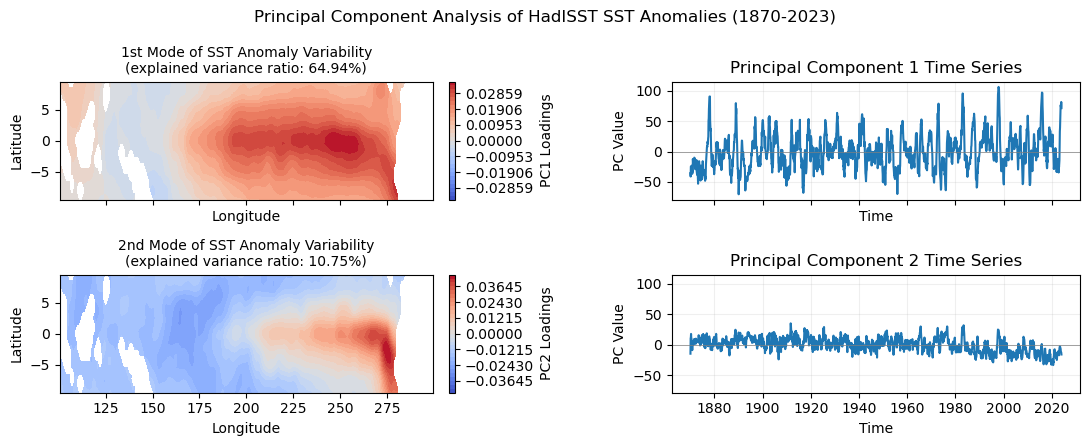

Saved PCA_Analysis_HadISST_SST_Anomalies_1870-2023.jpg to disk


In [26]:
# Close all figures to avoid issues when running the cell multiple times
# plt.close('all')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(11, 4.5), sharex='col', sharey='col')

###### 1st mode (PC axis 1) #######
first_loading = pca.components_[0] 
first_loading_reshaped = first_loading.reshape(n_lat, n_lon) # Reshape the first principal component loading back to the original spatial dimensions
max_abs_value = max(abs(np.min(first_loading_reshaped)), abs(np.max(first_loading_reshaped)))
countour_levels = np.linspace(-max_abs_value, max_abs_value, 31)  
first_loading_reshaped[land_mask] = np.nan 
im1 = axs[0,0].contourf(hadisst_sst_anom_slice['lon'], hadisst_sst_anom_slice['lat'], first_loading_reshaped, 
             cmap='coolwarm', levels=countour_levels, vmin=-max_abs_value, vmax=max_abs_value)
cbar1 = fig.colorbar(im1, ax=axs[0, 0], orientation='vertical', fraction=0.046, pad=0.04)
cbar1.set_label('PC1 Loadings')
axs[0,0].set_xlabel('Longitude')
axs[0,0].set_ylabel('Latitude')
axs[0,0].set_title(f'1st Mode of SST Anomaly Variability\n(explained variance ratio: {pca.explained_variance_ratio_[0]:.2%})', fontsize=10)


###### Projected Data: Principal Component 1 #######
axs[0, 1].plot(pca_scores.index, pca_scores['PC1'], label='Principal Component 1')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('PC Value')
axs[0, 1].set_title('Principal Component 1 Time Series')
axs[0, 1].grid(alpha=0.2)
axs[0, 1].axhline(y=0, color='grey', linewidth=0.5)



###### 2nd mode (PC axis 2) #######
second_loading = pca.components_[1] 
second_loading_reshaped = second_loading.reshape(n_lat, n_lon)
max_abs_value = max(abs(np.min(second_loading_reshaped)), abs(np.max(second_loading_reshaped)))
countour_levels = np.linspace(-max_abs_value, max_abs_value, 31)  
second_loading_reshaped[land_mask] = np.nan
im2 = axs[1,0].contourf(hadisst_sst_anom_slice['lon'], hadisst_sst_anom_slice['lat'], second_loading_reshaped, 
             cmap='coolwarm', levels=countour_levels, vmin=-max_abs_value, vmax=max_abs_value)
cbar2 = fig.colorbar(im2, ax=axs[1, 0], orientation='vertical', fraction=0.046, pad=0.04)
cbar2.set_label('PC2 Loadings')
axs[1,0].set_xlabel('Longitude')
axs[1,0].set_ylabel('Latitude')
axs[1,0].set_title(f'2nd Mode of SST Anomaly Variability\n(explained variance ratio: {pca.explained_variance_ratio_[1]:.2%})', fontsize=10)


###### Projected Data: Principal Component 2 #######
axs[1, 1].plot(pca_scores.index, pca_scores['PC2'], label='Principal Component 2')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('PC Value')
axs[1, 1].set_title('Principal Component 2 Time Series')
axs[1, 1].grid(alpha=0.2)
axs[1, 1].axhline(y=0, color='grey', linewidth=0.5)


plt.suptitle(f"Principal Component Analysis of HadISST SST Anomalies ({pca_scores.index[0].year}-{pca_scores.index[-1].year})")
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)


img_filename = f"PCA_Analysis_HadISST_SST_Anomalies_{pca_scores.index[0].year}-{pca_scores.index[-1].year}.jpg"
if SAVE_PLOTS_TO_DISK == True:
    fig.savefig(IMG_FOLDER + img_filename, dpi=300, bbox_inches='tight')

plt.show()

if SAVE_PLOTS_TO_DISK == True:
    print(f"Saved {img_filename} to disk")
        
plt.show()

### Process the PCA scores

In [27]:
pca_scores

,PC1,PC2
1870-01-16 11:59:59.505615,-35.506332,-14.820764
1870-02-14 23:59:59.340820,-41.041164,10.664654
1870-03-16 11:59:59.340820,-24.633518,12.065739
1870-04-15 23:59:59.340820,-23.889597,17.734203
1870-05-16 12:00:00.000000,-34.822926,11.401614
...,...,...
2023-08-16 12:00:00.000000,76.526192,-7.026896
2023-09-16 00:00:00.000000,74.531403,-11.748581
2023-10-16 12:00:00.000000,72.768913,-12.136766
2023-11-16 00:00:00.000000,81.760353,-12.876910


### Yearly DJF

#### Calculate DJF-Mean PCA Scores per year

In [28]:
# Create a new column 'DJF_year' to represent the year for DJF period
pca_scores['DJF_year'] = pca_scores.index.year

# Make December belong to the next year
pca_scores.loc[pca_scores.index.month == 12, 'DJF_year'] += 1  

# Filter data to only include December, January, and February
pca_scores_djf = pca_scores[pca_scores.index.month.isin([12, 1, 2])]

# Group by the new 'DJF_year' and calculate the mean
pca_scores_djf_mean = pca_scores_djf.groupby('DJF_year')[['PC1', 'PC2']].mean()
pca_scores_djf_mean

,PC1,PC2
DJF_year,,
1870,-38.273750,-2.078055
1871,-20.775421,3.399211
1872,-26.830591,3.075236
1873,-38.092754,6.526259
1874,-39.657742,1.244769
...,...,...
2020,23.920107,-27.698807
2021,-26.107538,-9.884484
2022,-26.555971,-22.621048


#### Standardize the DJF-Mean PCA scores over the Base Period

In [29]:
# Normalize the PCs by the Standard Deviation for the Base Period
print(pca_scores_djf_mean.loc[BASE_PERIOD_START_yr:BASE_PERIOD_END_yr])
pca_scores_djf_mean_mean = pca_scores_djf_mean.loc[BASE_PERIOD_START_yr:BASE_PERIOD_END_yr].mean()
print(f'\npca_scores_djf_mean\'s mean: \n{pca_scores_djf_mean_mean}')
pca_scores_djf_mean_std = pca_scores_djf_mean.loc[BASE_PERIOD_START_yr:BASE_PERIOD_END_yr].std()
print(f'\npca_scores_djf_mean\'s std: \n{pca_scores_djf_mean_std}')

                PC1        PC2
DJF_year                      
1961      -0.134378  -0.303626
1962     -12.202863   7.699071
1963     -16.026394   1.156536
1964      18.600637  -4.577261
1965     -23.564516  13.327104
1966      40.373417   4.628348
1967     -14.913465   2.118276
1968     -27.362871  -4.481602
1969      28.459589 -14.565286
1970      23.705645  -5.149168
1971     -48.597198   5.798888
1972     -19.291883   5.538857
1973      58.175495   4.266893
1974     -56.412876  16.012121
1975     -22.569815   7.829462
1976     -53.708263  18.675535
1977      24.122507   6.856234
1978      19.147282  -4.260512
1979       3.063413  -2.676301
1980      20.277597  -8.780229
1981      -9.315431  -9.773818
1982       7.440711  -3.859315
1983      91.766182  21.540247
1984     -10.474967  -6.621365
1985     -32.291355  -4.167137
1986     -15.389969 -10.831561
1987      39.498871   0.289046
1988      33.599606 -17.429161
1989     -46.295277   6.742445
1990       2.957274 -12.576652

pca_sco

In [30]:
pca_scores_djf_mean.head()

,PC1,PC2
DJF_year,,
1870,-38.273750,-2.078055
1871,-20.775421,3.399211
1872,-26.830591,3.075236
1873,-38.092754,6.526259
1874,-39.657742,1.244769


In [31]:
pca_scores_djf_mean_norm = (pca_scores_djf_mean - pca_scores_djf_mean_mean) / pca_scores_djf_mean_std
pca_scores_djf_mean_norm.head()

,PC1,PC2
DJF_year,,
1870,-1.118105,-0.258407
1871,-0.608091,0.309497
1872,-0.784578,0.275906
1873,-1.112829,0.633721
1874,-1.158443,0.086116


In [32]:
# Invert the sign of all points in the DataFrame to match takahashi's paper
pca_scores_djf_mean_norm['PC2'] = -pca_scores_djf_mean_norm['PC2']

#### Calculate the E and C indices

In [33]:
# Thecorresponding indices are defined as (which is equivalent to rotating the PC1 and PC2 axes by 45°)
# C = PC1 + PC2 / √2
# E = PC1 - PC2 / √2
pca_scores_djf_mean_norm['C'] = (pca_scores_djf_mean_norm['PC1'] + pca_scores_djf_mean_norm['PC2']) / np.sqrt(2)
pca_scores_djf_mean_norm['E'] = (pca_scores_djf_mean_norm['PC1'] - pca_scores_djf_mean_norm['PC2']) / np.sqrt(2)
pca_scores_djf_mean_norm.head()

,PC1,PC2,C,E
DJF_year,,,,
1870,-1.118105,0.258407,-0.607898,-0.973341
1871,-0.608091,-0.309497,-0.648833,-0.211138
1872,-0.784578,-0.275906,-0.749875,-0.359685
1873,-1.112829,-0.633721,-1.234998,-0.338781
1874,-1.158443,-0.086116,-0.880036,-0.758250


#### Plot Normalized DJF-Mean PCA Scores

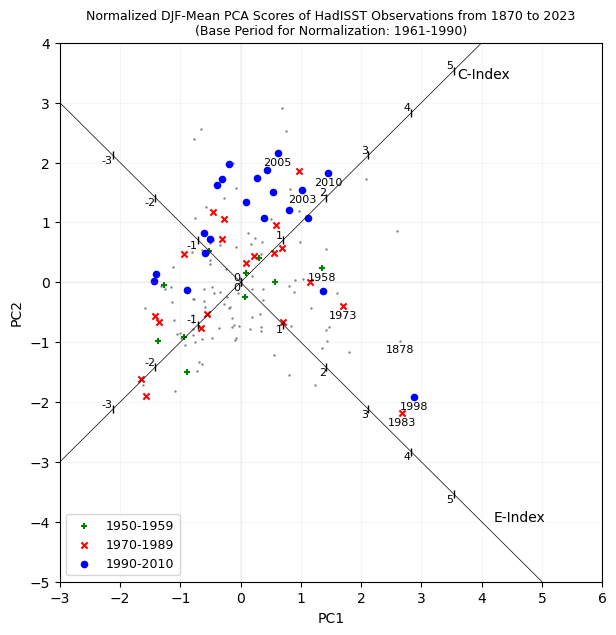

Saved PCA_Scores_HadISST_SST_Anomalies_1870-2023.jpg to disk


,PC1,PC2,C,E
DJF_year,,,,
1969,0.826934,1.553130,1.682959,-0.513498
1988,0.976747,1.850067,1.998859,-0.617531
1991,0.433635,1.869667,1.628680,-1.015428
1995,1.123072,1.080785,1.558363,0.029902
2003,1.024747,1.533493,1.808948,-0.359738
2005,0.617338,2.153966,1.959608,-1.086560
2010,1.448758,1.823886,2.314109,-0.265255
2015,0.760867,2.522510,2.321698,-1.245669
2016,2.594708,0.850858,2.436383,1.233088


,PC1,PC2,C,E
DJF_year,,,,
1878,2.642644,-0.977298,1.177577,2.559685
1889,1.795112,-1.169525,0.442357,2.096315
1897,1.432099,-0.978726,0.320584,1.704711
1900,1.460740,-0.741126,0.508844,1.556954
1912,1.229733,-1.717303,-0.344764,2.083870
1914,0.799676,-1.554277,-0.533583,1.664496
1919,1.355703,-1.098072,0.182173,1.735081
1926,1.410456,-0.789047,0.439402,1.555283
1983,2.672095,-2.190428,0.340590,3.438323


,PC1,PC2,C,E
DJF_year,,,,
1983,2.672095,-2.190428,0.340590,3.438323
1998,2.872173,-1.920632,0.672841,3.389025


In [34]:
time_ranges = [('1950', '1959'), ('1970', '1989'), ('1990', '2010'),]
colors = ['green', 'red', 'blue']
markers = ['+', 'x', 'o']

plt.figure(figsize=(7, 7))

# plot all points
plt.scatter(pca_scores_djf_mean_norm['PC1'], pca_scores_djf_mean_norm['PC2'], color='grey', marker='o', s=0.5)

# emphasize specific points within time ranges
for time_range, color, marker in zip(time_ranges, colors, markers):
    subset = pca_scores_djf_mean_norm.loc[time_range[0]:time_range[1]]
    plt.scatter(subset['PC1'], subset['PC2'], color=color, marker=marker, s=20, label=f'{time_range[0]}-{time_range[1]}')


# Add labels to each point matching labels from Takahashi et al. paper
for year in pca_scores_djf_mean_norm.index:
    if year in [1878, 1958, 1973, 1983, 1998, 2003, 2005, 2010]: 
        x = pca_scores_djf_mean_norm.loc[year, 'PC1']
        y = pca_scores_djf_mean_norm.loc[year, 'PC2']
        plt.text(x, y - 0.2, str(year), fontsize=8, ha='center')
        
# PC1 and PC2 axes 
plt.axhline(y=0, color='grey', linewidth=0.1)
plt.axvline(x=0, color='grey', linewidth=0.1)

# C-Index line 
plt.axline((0, 0), slope=1., color='black', linewidth=0.5)

# E-Index line
plt.axline((0, 0), slope=-1., color='black', linewidth=0.5)

# Add labels to the lines
plt.annotate('C-Index', xy=(3.6, 3.4), fontsize=10, color='black')
plt.annotate('E-Index', xy=(4.2, -4), fontsize=10, color='black')


# Add ticks and labels for C-Index and E-Index
for i in range(-3, 6):
    tick_value = i / np.sqrt(2)
    # C-Index ticks
    plt.plot(tick_value, tick_value, marker='|', color='black')
    plt.text(tick_value, tick_value, str(i), fontsize=8, ha='right', va='bottom')
    
    # E-Index ticks
    plt.plot(tick_value, -tick_value, marker='|', color='black')
    plt.text(tick_value, -tick_value, str(i), fontsize=8, ha='right', va='top')
    

# Set plot labels and title
plt.xlabel('PC1')
plt.xlim(-3,6)
plt.ylabel('PC2')
plt.ylim(-5,4)
plt.legend(fontsize=9, loc="lower left")
plt.grid(alpha=0.1)

img_filename = f"PCA_Scores_HadISST_SST_Anomalies_{pca_scores.index[0].year}-{pca_scores.index[-1].year}.jpg"

if SAVE_PLOTS_TO_DISK == True:
    plt.savefig(IMG_FOLDER + img_filename, dpi=300, bbox_inches='tight')

plt.title(f'Normalized DJF-Mean PCA Scores of HadISST Observations from {start_year} to {end_year}\n(Base Period for Normalization: {BASE_PERIOD_START_yr}-{BASE_PERIOD_END_yr})', fontsize=9)
plt.show()

if SAVE_PLOTS_TO_DISK == True:
    print(f"Saved {img_filename} to disk")



display(pca_scores_djf_mean_norm[pca_scores_djf_mean_norm['C'] > 1.5].style.set_caption("<b>C-index > 1.5</b>"))
print("\n\n")
display(pca_scores_djf_mean_norm[pca_scores_djf_mean_norm['E'] > 1.5].style.set_caption("<b>E-index > 1.5</b>"))
print("\n\n")
display(pca_scores_djf_mean_norm[pca_scores_djf_mean_norm['E'] > 3].style.set_caption("<b>E-index > 3</b>"))


### Monthly 

#### Standardize the Montly PCA scores over the Base Period

In [35]:
pca_scores = pca_scores.drop(columns='DJF_year')

In [36]:
BASE_PERIOD_START_yr, BASE_PERIOD_END_yr

('1961', '1990')

In [37]:
# Normalize the PCs by the Standard Deviation for the Base Period
print(pca_scores.loc[BASE_PERIOD_START_yr:BASE_PERIOD_END_yr])

pca_scores_mean = pca_scores.loc[BASE_PERIOD_START_yr:BASE_PERIOD_END_yr].mean()
print(f'\npca_scores_mean: \n{pca_scores_mean}')
pca_scores_std = pca_scores.loc[BASE_PERIOD_START_yr:BASE_PERIOD_END_yr].std()
print(f'\npca_scores_std: \n{pca_scores_std}')

                           PC1        PC2
1961-01-16 12:00:00  -4.878310   3.494143
1961-02-15 00:00:00   6.595056   5.175129
1961-03-16 12:00:00   0.115254   6.702605
1961-04-16 00:00:00   8.088863   5.962090
1961-05-16 12:00:00   3.612175   7.219676
...                        ...        ...
1990-08-16 12:00:00   9.328928 -21.258896
1990-09-16 00:00:00  10.954286 -14.275981
1990-10-16 12:00:00   8.050899 -22.683764
1990-11-16 00:00:00   6.583786 -18.477995
1990-12-16 12:00:00  11.910488 -19.231184

[360 rows x 2 columns]

pca_scores_mean: 
PC1    0.243783
PC2    0.306968
dtype: float32

pca_scores_std: 
PC1    30.308262
PC2    11.690378
dtype: float32


In [38]:
pca_scores_norm = (pca_scores - pca_scores_mean) / pca_scores_std
pca_scores_norm.head()

,PC1,PC2
1870-01-16 11:59:59.505615,-1.179550,-1.294033
1870-02-14 23:59:59.340820,-1.362168,0.886001
1870-03-16 11:59:59.340820,-0.820809,1.005850
1870-04-15 23:59:59.340820,-0.796264,1.490733
1870-05-16 12:00:00.000000,-1.157002,0.949041


In [39]:
# Invert the sign of all points in the DataFrame to match takahashi's paper
pca_scores_norm['PC2'] = -pca_scores_norm['PC2']

#### Calculate the E and C monthly indices

In [40]:
# Thecorresponding indices are defined as (which is equivalent to rotating the PC1 and PC2 axes by 45°)
# C = PC1 + PC2 / √2
# E = PC1 - PC2 / √2
pca_scores_norm['C'] = (pca_scores_norm['PC1'] + pca_scores_norm['PC2']) / np.sqrt(2)
pca_scores_norm['E'] = (pca_scores_norm['PC1'] - pca_scores_norm['PC2']) / np.sqrt(2)
pca_scores_norm.head()

,PC1,PC2,C,E
1870-01-16 11:59:59.505615,-1.179550,1.294033,0.080951,-1.749087
1870-02-14 23:59:59.340820,-1.362168,-0.886001,-1.589696,-0.336701
1870-03-16 11:59:59.340820,-0.820809,-1.005850,-1.291643,0.130844
1870-04-15 23:59:59.340820,-0.796264,-1.490733,-1.617151,0.491064
1870-05-16 12:00:00.000000,-1.157002,-0.949041,-1.489197,-0.147050


In [41]:
# reproduce Tello's plot in 2.GODAS_indices.ipynb
pca_scores_norm

,PC1,PC2,C,E
1870-01-16 11:59:59.505615,-1.179550,1.294033,0.080951,-1.749087
1870-02-14 23:59:59.340820,-1.362168,-0.886001,-1.589696,-0.336701
1870-03-16 11:59:59.340820,-0.820809,-1.005850,-1.291643,0.130844
1870-04-15 23:59:59.340820,-0.796264,-1.490733,-1.617151,0.491064
1870-05-16 12:00:00.000000,-1.157002,-0.949041,-1.489197,-0.147050
...,...,...,...,...
2023-08-16 12:00:00.000000,2.516885,0.627342,2.223304,1.336109
2023-09-16 00:00:00.000000,2.451068,1.031237,2.462362,1.003973
2023-10-16 12:00:00.000000,2.392916,1.064442,2.444722,0.939373
2023-11-16 00:00:00.000000,2.689583,1.127755,2.699265,1.104379


In [42]:
pca_scores_norm['E']

1870-01-16 11:59:59.505615   -1.749087
1870-02-14 23:59:59.340820   -0.336701
1870-03-16 11:59:59.340820    0.130844
1870-04-15 23:59:59.340820    0.491064
1870-05-16 12:00:00.000000   -0.147050
                                ...   
2023-08-16 12:00:00.000000    1.336109
2023-09-16 00:00:00.000000    1.003973
2023-10-16 12:00:00.000000    0.939373
2023-11-16 00:00:00.000000    1.104379
2023-12-16 12:00:00.000000    0.670967
Name: E, Length: 1848, dtype: float32

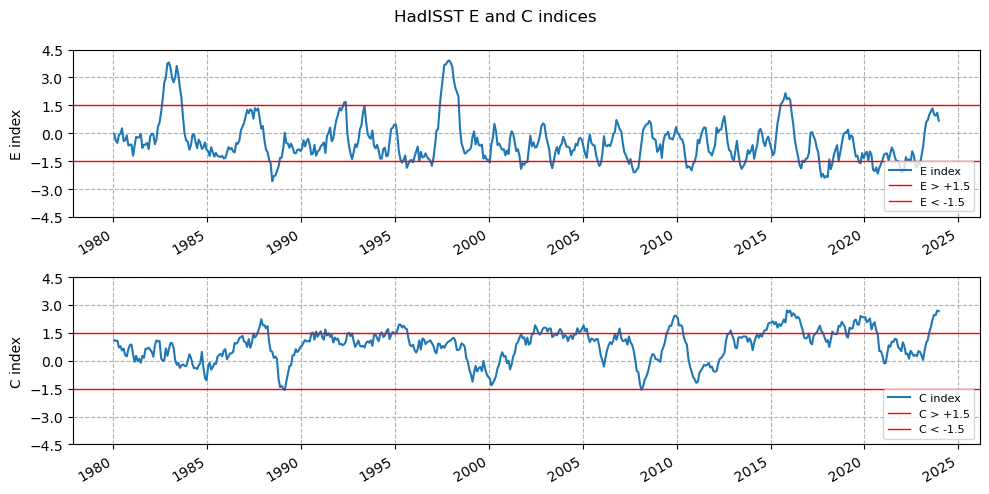

In [43]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 5))
for ax, index in zip(axs, ['E', 'C']):
    pca_scores_norm.loc['1980-1-1':, index].plot(ax=ax, label=f"{index} index")
    ax.axhline(y=-1.5, color='red', linewidth=1, label=f"{index} > +1.5")
    ax.axhline(y=1.5, color='red', linewidth=1, label=f"{index} < -1.5")
    ax.set_ylabel(f"{index} index")
    ax.set_ylim(-4.5, 4.5) 
    ax.set_yticks(np.arange(-4.5, 6, 1.5))
    ax.grid(linestyle='--')
    ax.legend(loc='lower right', fontsize=8)

plt.suptitle("HadISST E and C indices")
plt.tight_layout()
plt.show()

In [44]:

# display(pca_scores_norm[pca_scores_norm['C'] > 1.5].style.set_caption("<b>C-index > 1.5</b>"))
# print("\n\n")
# display(pca_scores_norm[pca_scores_norm['E'] > 1.5].style.set_caption("<b>E-index > 1.5</b>"))
# print("\n\n")
# display(pca_scores_norm[pca_scores_norm['E'] > 3].style.set_caption("<b>E-index > 3</b>"))


#### Plot Normalized Monthly PCA Scores

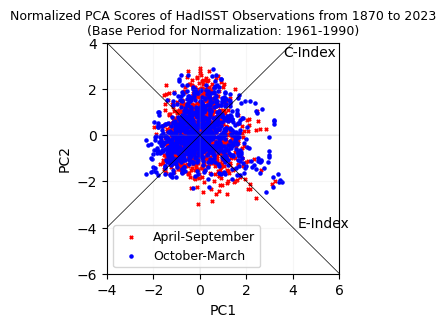

In [45]:
plt.figure(figsize=(3, 3))

# April–September: red crosses
pca_scores_apr_sep = pca_scores_norm[~pca_scores_norm.index.month.isin([10, 11, 12, 1, 2, 3])]
plt.scatter(pca_scores_apr_sep['PC1'], pca_scores_apr_sep['PC2'], color='red', marker='x', s=5, label='April-September')

# October–March: blue circles
pca_scores_oct_mar = pca_scores_norm[pca_scores_norm.index.month.isin([10, 11, 12, 1, 2, 3])]
plt.scatter(pca_scores_oct_mar['PC1'], pca_scores_oct_mar['PC2'], color='blue', marker='o', s=5, label='October-March')
        
# PC1 and PC2 axes 
plt.axhline(y=0, color='grey', linewidth=0.1)
plt.axvline(x=0, color='grey', linewidth=0.1)

# C-Index line 
plt.axline((0, 0), slope=1., color='black', linewidth=0.5)

# E-Index line
plt.axline((0, 0), slope=-1., color='black', linewidth=0.5)

# Add labels to the lines
plt.annotate('C-Index', xy=(3.6, 3.4), fontsize=10, color='black')
plt.annotate('E-Index', xy=(4.2, -4), fontsize=10, color='black')

# Set plot labels and title
plt.xlabel('PC1')
plt.xlim(-4,6)
plt.ylabel('PC2')
plt.ylim(-6,4)
plt.legend(fontsize=9, loc="lower left")
plt.title(f'Normalized PCA Scores of HadISST Observations from {pca_scores_norm.index[0].year} to {pca_scores_norm.index[-1].year}\n(Base Period for Normalization: {BASE_PERIOD_START_yr}-{BASE_PERIOD_END_yr})', fontsize=9)
plt.grid(alpha=0.1)
plt.show()

## Compute and Plot EOFs for CMIP datasets

In [46]:
    # elif source_id.split("-")[0] == "GODAS":
    #     if target == "oni":
    #         target_folder = GODAS_ONI_FOLDER
    #         target_var_name = 'oni'
    #     elif target == "nino34":
    #         target_folder = GODAS_NINO34_FOLDER
    #         target_var_name = 'nino34'
    #     elif target == "E":
    #         target_folder = GODAS_EC_FOLDER
    #         target_var_name = 'E'
    #     elif target == "C":
    #         target_folder = GODAS_EC_FOLDER
    #         target_var_name = 'C'
    #     else:
    #         print(f"Unknown target {target}. Abort")
    #         return

In [47]:
pca_ec_indices_dict = {}

for source_id in ['HADISST', 'MRI-ESM2-0', 'MIROC6', 'BCC-ESM1', 'FGOALS-f3-L', 'GISS-E2-1-G', 'GODAS']:

    if source_id == 'HADISST':
        filename, filepath = find_file(HadISST_ANOM_1M_FOLDER, source_id)
        savepath = HadISST_EC_FOLDER
    elif source_id == 'GODAS':
        filename, filepath = find_file(GODAS_ANOM_1M_FOLDER, source_id)
        savepath = GODAS_EC_FOLDER
    else:
        filename, filepath = find_file(CMIP6_ANOM_1M_FOLDER, source_id)
        savepath = CMIP6_EC_FOLDER 
    os.makedirs(savepath, exist_ok=True) 


    # create new file name
    new_filename = filename.replace("regridded_tos_anom_1m.nc", "pca_ec_indices.txt")
    file_out = os.path.join(savepath, new_filename)

    # if ec_index file already exist on disk, load it
    # if os.path.isfile(file_out):
    #     print(f"{new_filename} already exist in {savepath}. Loading it from disk...\n")
    #     pca_ec_indices_dict[source_id] = pd.read_csv(file_out, sep='\t', index_col=0) 
    #     pca_ec_indices_dict[source_id].index = pd.to_datetime(pca_ec_indices_dict[source_id].index)

    #     continue


    
    print(filename)
    print(filepath)
    ########## Load dataset ##########
    cmip_anom_1m_ds = xr.open_dataset(filepath)
    
    # Squeeze out dimensions of size one, if any (e.g. member_id, dcpp_init_year)
    cmip_anom_1m_squeezed_ds = cmip_anom_1m_ds.squeeze()

    ########## Calculate the first two EOF modes of SST anomalies ##########
    
    cmip_sst_anom_slice = cmip_anom_1m_squeezed_ds["tos_anom_1m"].sel(time=slice(start_date, end_date),
                                                                            lat=slice(MIN_LAT, MAX_LAT),
                                                                            lon=slice(MIN_LON, MAX_LON))
    
    # Get the number of time steps, and latitude and longitude dimensions
    n_time_steps = cmip_sst_anom_slice.coords['time'].size
    n_lat = cmip_sst_anom_slice.coords['lat'].size
    n_lon = cmip_sst_anom_slice.coords['lon'].size
    
    # Create a land mask where True indicates land and False indicates ocean
    land_mask = np.isnan(cmip_sst_anom_slice[0].values)
    
    # Replace NaN values with 0
    cmip_sst_anom_slice = cmip_sst_anom_slice.fillna(0)
    
    # reshape sst_anom into a 2D array: (time_steps, lat * lon)
    cmip_sst_anom_slice_2d = cmip_sst_anom_slice.values.reshape(n_time_steps, -1)
    
    # Project to a new array of shape (n_samples, n_components)
    pca = sklearn.decomposition.PCA(n_components=2)
    pca.fit(cmip_sst_anom_slice_2d)
    projected_data = pca.transform(cmip_sst_anom_slice_2d)
    
    # convert to a dataframe
    pca_scores = pd.DataFrame(projected_data, columns=['PC1', 'PC2'])
    
    # replace numerical index with datetime
    pca_scores.index = pd.to_datetime(cmip_sst_anom_slice['time'].values)
    
    
    ########## Standardize the Montly PCA scores over the Base Period ########## 
    pca_scores_mean = pca_scores.loc[BASE_PERIOD_START_yr:BASE_PERIOD_END_yr].mean()
    pca_scores_std = pca_scores.loc[BASE_PERIOD_START_yr:BASE_PERIOD_END_yr].std()
    pca_scores_norm = (pca_scores - pca_scores_mean) / pca_scores_std
    pca_scores_norm['PC2'] = -pca_scores_norm['PC2']

    ########## Calculate C and E indices ########## 
    # E = PC1 - PC2 / √2
    # C = PC1 + PC2 / √2
    pca_scores_norm['C'] = (pca_scores_norm['PC1'] + pca_scores_norm['PC2']) / np.sqrt(2)
    pca_scores_norm['E'] = (pca_scores_norm['PC1'] - pca_scores_norm['PC2']) / np.sqrt(2)

    
    pca_scores_norm['C_strong'] = pca_scores_norm['C'].apply(lambda x: 1 if x > 1.5 else 0)
    pca_scores_norm['E_strong'] = pca_scores_norm['E'].apply(lambda x: 1 if x > 1.5 else 0)
    
    # display(pca_scores_norm)
    
    pca_scores_norm.to_csv(file_out, header=True, index=True, sep='\t')
    print('file written: {}\n'.format(file_out))
    
    # store in dict
    pca_ec_indices_dict[source_id] = pca_scores_norm

OBS.HAD.HADISST.regridded_tos_anom_1m.nc
datasets/HadISST/HadISST_regridded/anom_1m/OBS.HAD.HADISST.regridded_tos_anom_1m.nc
file written: datasets/HadISST/HadISST_regridded/ec_indices/OBS.HAD.HADISST.pca_ec_indices.txt

CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc
datasets/CMIP6/CMIP6_regridded/anom_1m/CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc
file written: datasets/CMIP6/CMIP6_regridded/ec_indices/CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.pca_ec_indices.txt

CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc
datasets/CMIP6/CMIP6_regridded/anom_1m/CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc
file written: datasets/CMIP6/CMIP6_regridded/ec_indices/CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.pca_ec_indices.txt

CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc
datasets/CMIP6/CMIP6_regridded/anom_1m/CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_t

In [48]:
list(pca_ec_indices_dict.keys())

['HADISST',
 'MRI-ESM2-0',
 'MIROC6',
 'BCC-ESM1',
 'FGOALS-f3-L',
 'GISS-E2-1-G',
 'GODAS']

In [49]:
pca_ec_indices_dict['GISS-E2-1-G'][['C_strong', 'E_strong']].value_counts()

C_strong  E_strong
0         0           1796
          1            133
1         0             50
          1              1
Name: count, dtype: int64

In [50]:
pca_ec_indices_dict.keys()

dict_keys(['HADISST', 'MRI-ESM2-0', 'MIROC6', 'BCC-ESM1', 'FGOALS-f3-L', 'GISS-E2-1-G', 'GODAS'])

### Plot all PC1-PC2 spaces

HADISST
MRI-ESM2-0
MIROC6
BCC-ESM1
FGOALS-f3-L
GISS-E2-1-G


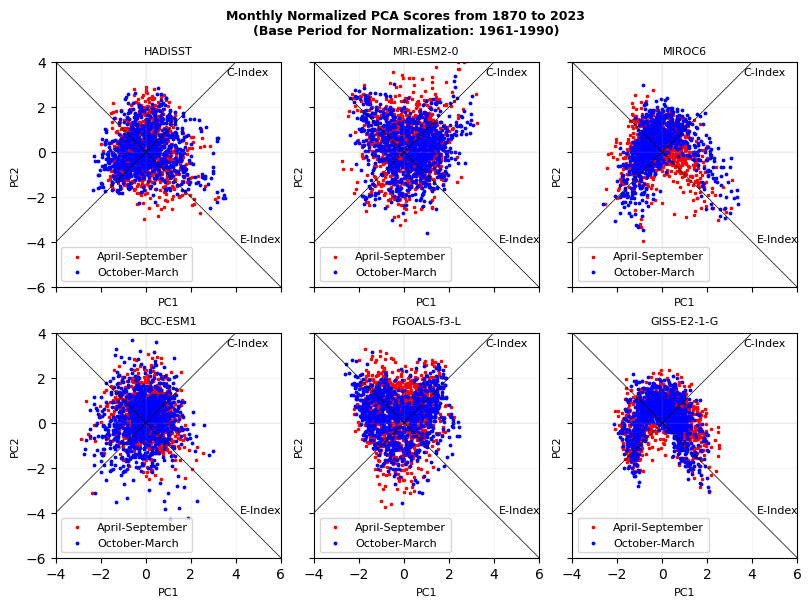

In [51]:
fig, axs = plt.subplots(figsize=(8, 6), nrows=2, ncols=3, sharex=True, sharey=True, layout='compressed')
for i, ((source_id, model_dict), ax) in enumerate(zip(pca_ec_indices_dict.items(), axs.flat)):
    print(source_id)
    ########## Plot Normalized Monthly PCA Scores ########## 
    
    # April–September: red crosses
    pca_scores_apr_sep = pca_ec_indices_dict[source_id][~pca_ec_indices_dict[source_id].index.month.isin([10, 11, 12, 1, 2, 3])]
    # display(pca_scores_apr_sep)
    ax.scatter(pca_scores_apr_sep['PC1'], pca_scores_apr_sep['PC2'], color='red', marker='x', s=3, label='April-September')
    
    # October–March: blue circles
    pca_scores_oct_mar = pca_ec_indices_dict[source_id][pca_ec_indices_dict[source_id].index.month.isin([10, 11, 12, 1, 2, 3])]
    ax.scatter(pca_scores_oct_mar['PC1'], pca_scores_oct_mar['PC2'], color='blue', marker='o', s=3, label='October-March')
            
    # PC1 and PC2 axes 
    ax.axhline(y=0, color='grey', linewidth=0.1)
    ax.axvline(x=0, color='grey', linewidth=0.1)
    
    # C-Index line 
    ax.axline((0, 0), slope=1., color='black', linewidth=0.5)
    
    # E-Index line
    ax.axline((0, 0), slope=-1., color='black', linewidth=0.5)
    
    # Add labels to the lines
    ax.annotate('C-Index', xy=(3.6, 3.4), fontsize=8, color='black')
    ax.annotate('E-Index', xy=(4.2, -4), fontsize=8, color='black')
    
    # Set plot labels and title
    ax.set_xlabel('PC1', fontsize=8)
    ax.set_xlim(-4,6)
    ax.set_ylabel('PC2', fontsize=8)
    ax.set_ylim(-6,4)
    ax.legend(fontsize=8, loc="lower left")
    ax.set_title(f'{source_id}', fontsize=8)
    ax.grid(alpha=0.1)
    
    ax.set_aspect('equal', 'box') # square aspect ratio

img_filename = f"PCA_Scores_All_Datasets_{pca_scores.index[0].year}-{pca_scores.index[-1].year}.jpg"
plt.savefig(IMG_FOLDER + img_filename, dpi=300, bbox_inches='tight')
plt.suptitle(f'Monthly Normalized PCA Scores from {start_year} to {end_year}\n(Base Period for Normalization: {BASE_PERIOD_START_yr}-{BASE_PERIOD_END_yr})', 
             fontweight='bold', fontsize=9)
plt.show()

# Monthly Normalized PCA Scores from 1970 to 2023. One point per month (october-march: blue points, april-september: orange points). The base period used for nomralization is 1961-1990.


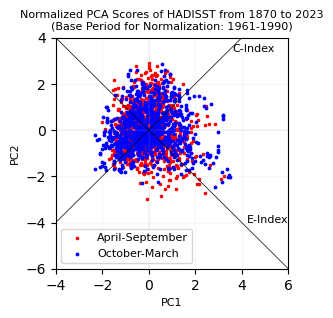

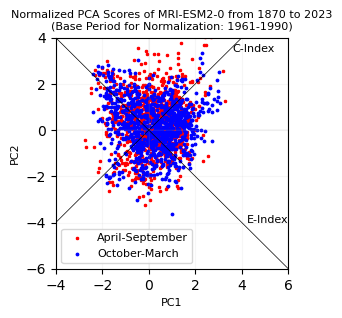

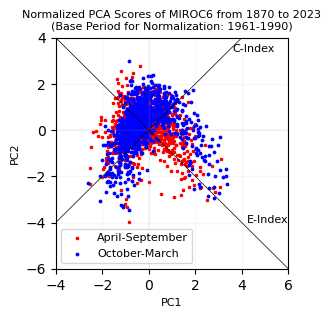

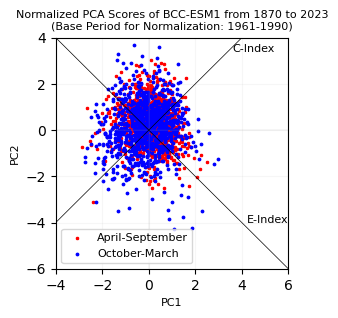

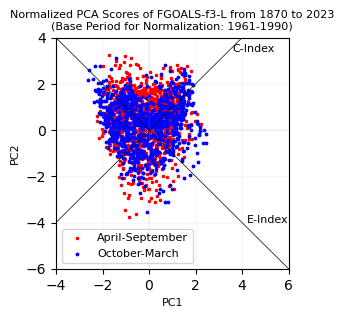

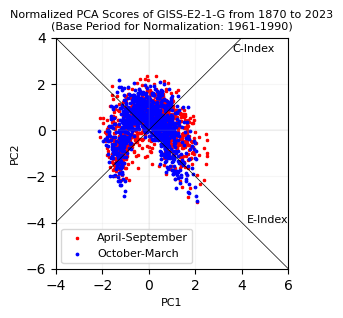

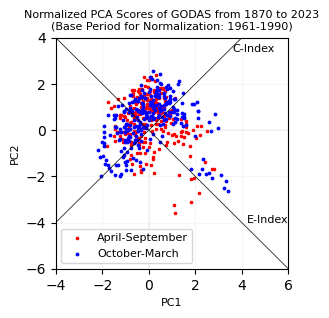

In [54]:
for source_id, pca_ec_indices in pca_ec_indices_dict.items():
    
    ########## Plot Normalized Monthly PCA Scores ########## 
    plt.figure(figsize=(3, 3))
    
    # April–September: red crosses
    pca_scores_apr_sep = pca_ec_indices_dict[source_id][~pca_ec_indices_dict[source_id].index.month.isin([10, 11, 12, 1, 2, 3])]
    plt.scatter(pca_scores_apr_sep['PC1'], pca_scores_apr_sep['PC2'], color='red', marker='x', s=3, label='April-September')
    
    # October–March: blue circles
    pca_scores_oct_mar = pca_ec_indices_dict[source_id][pca_ec_indices_dict[source_id].index.month.isin([10, 11, 12, 1, 2, 3])]
    plt.scatter(pca_scores_oct_mar['PC1'], pca_scores_oct_mar['PC2'], color='blue', marker='o', s=3, label='October-March')
            
    # PC1 and PC2 axes 
    plt.axhline(y=0, color='grey', linewidth=0.1)
    plt.axvline(x=0, color='grey', linewidth=0.1)
    
    # C-Index line 
    plt.axline((0, 0), slope=1., color='black', linewidth=0.5)
    
    # E-Index line
    plt.axline((0, 0), slope=-1., color='black', linewidth=0.5)
    
    # Add labels to the lines
    plt.annotate('C-Index', xy=(3.6, 3.4), fontsize=8, color='black')
    plt.annotate('E-Index', xy=(4.2, -4), fontsize=8, color='black')
    
    # Set plot labels and title
    plt.xlabel('PC1', fontsize=8)
    plt.xlim(-4,6)
    plt.ylabel('PC2', fontsize=8)
    plt.ylim(-6,4)
    plt.legend(fontsize=8, loc="lower left")
    plt.title(f'Normalized PCA Scores of {source_id} from {start_year} to {end_year}\n(Base Period for Normalization: {BASE_PERIOD_START_yr}-{BASE_PERIOD_END_yr})', fontsize=8)
    plt.grid(alpha=0.1)
    plt.show()

### Plot all PC1-PC2 spaces with time series

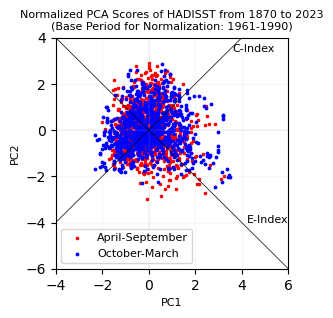

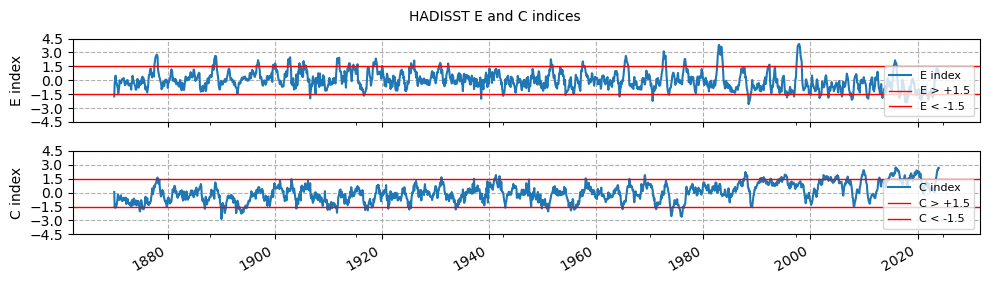

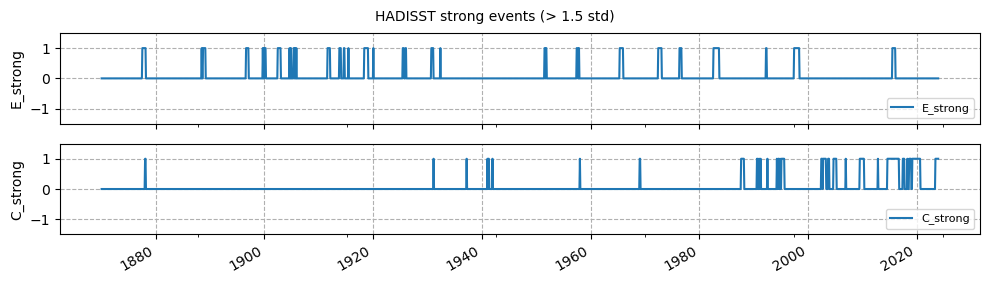

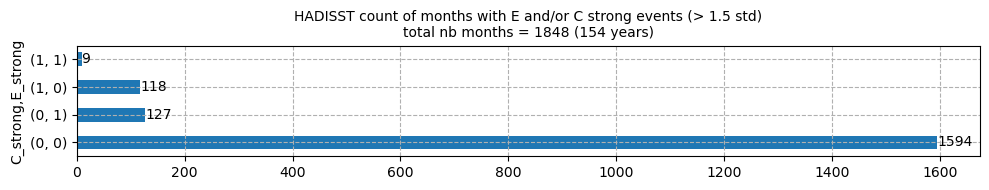

Number of months with E strong events (E > 1.5): 136/1848 (7.36%)
Number of months with C strong events (C > 1.5): 127/1848 (6.87%)







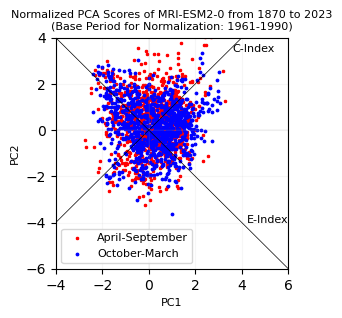

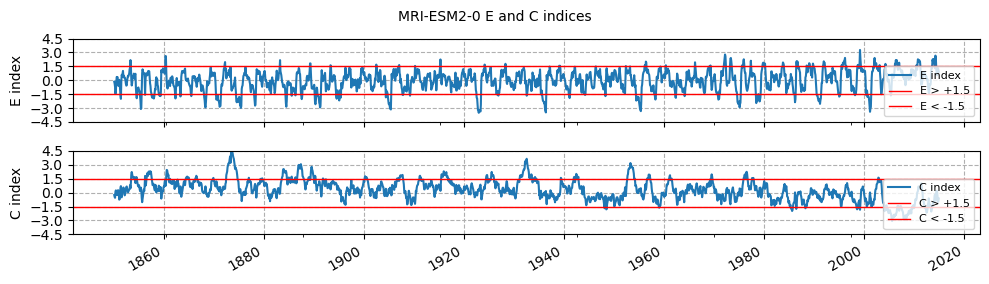

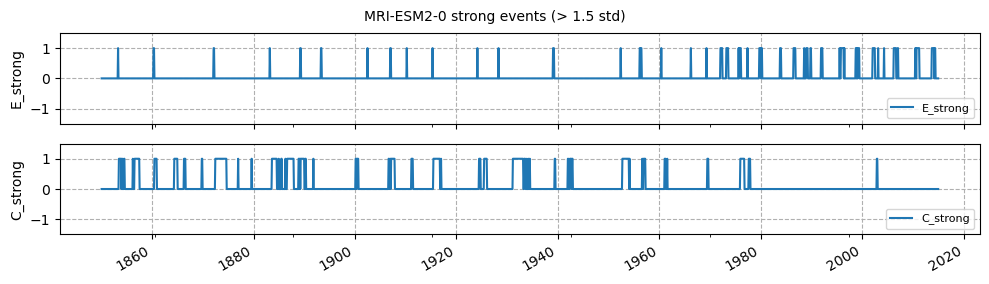

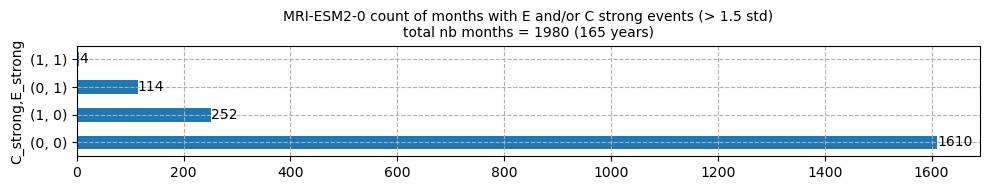

Number of months with E strong events (E > 1.5): 118/1980 (5.96%)
Number of months with C strong events (C > 1.5): 256/1980 (12.93%)







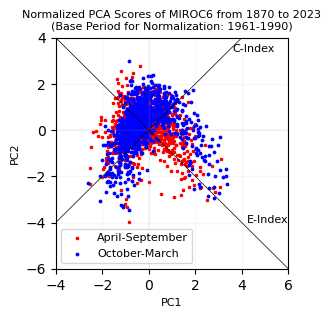

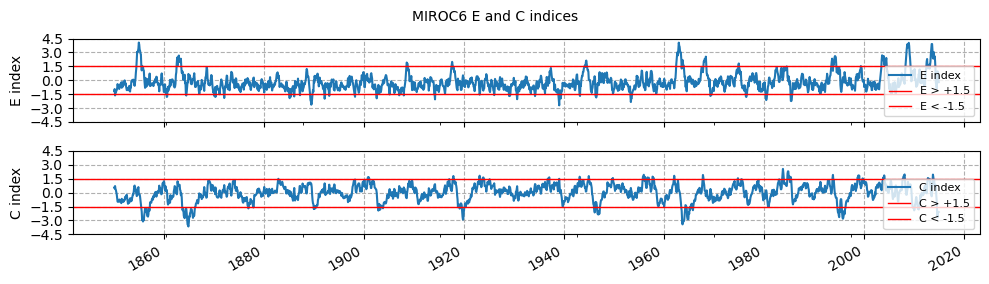

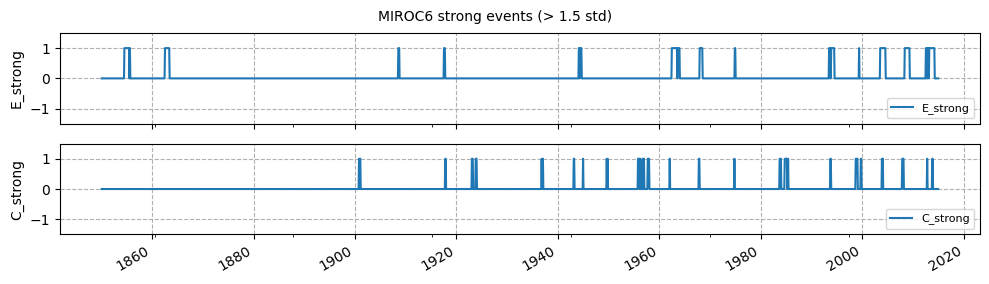

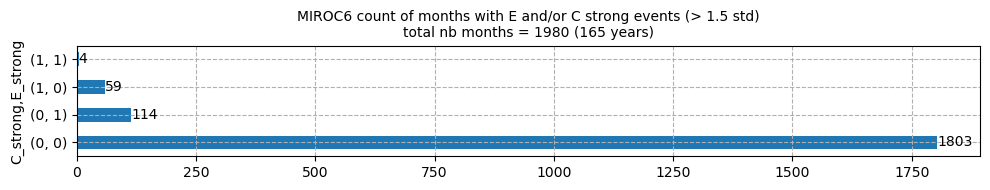

Number of months with E strong events (E > 1.5): 118/1980 (5.96%)
Number of months with C strong events (C > 1.5):  63/1980 (3.18%)







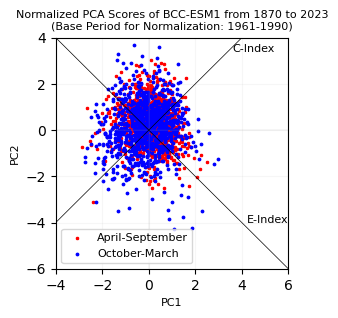

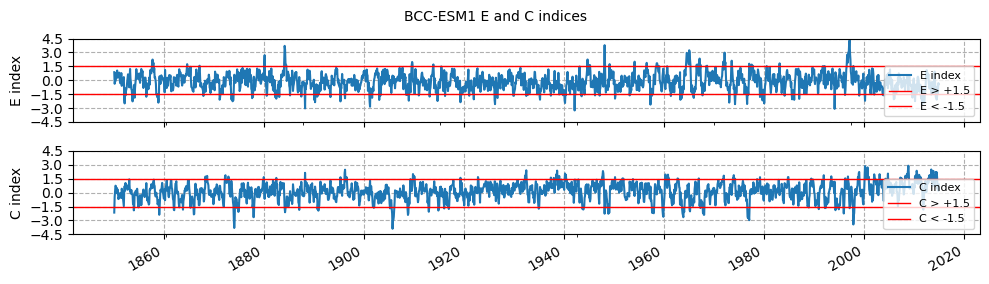

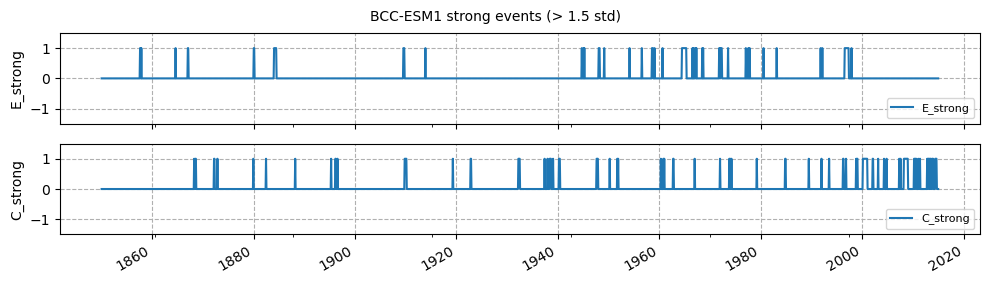

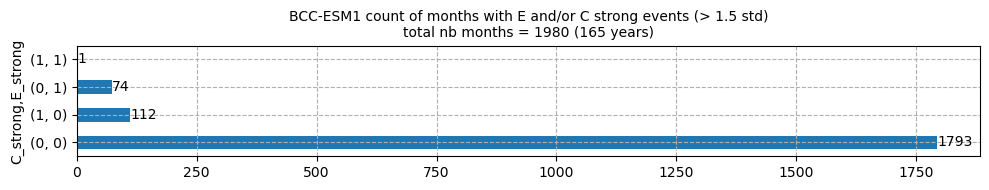

Number of months with E strong events (E > 1.5):  75/1980 (3.79%)
Number of months with C strong events (C > 1.5): 113/1980 (5.71%)







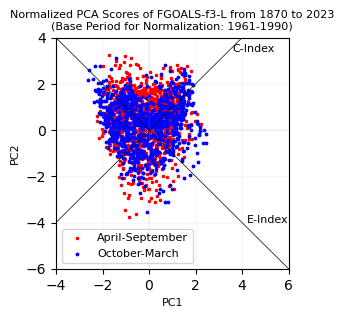

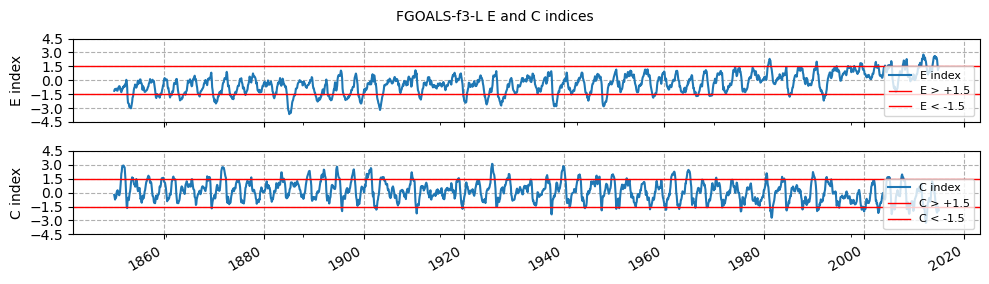

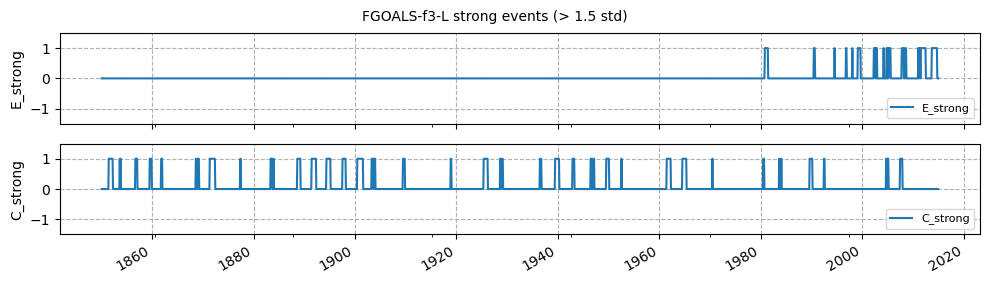

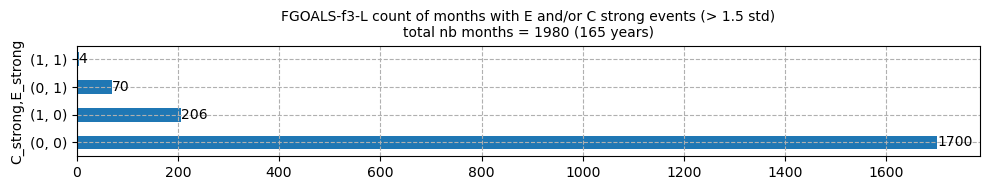

Number of months with E strong events (E > 1.5):  74/1980 (3.74%)
Number of months with C strong events (C > 1.5): 210/1980 (10.61%)







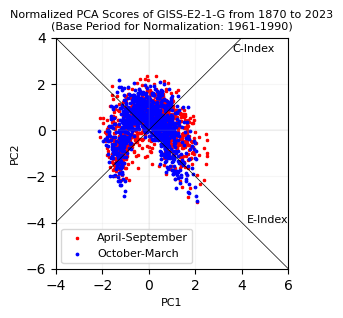

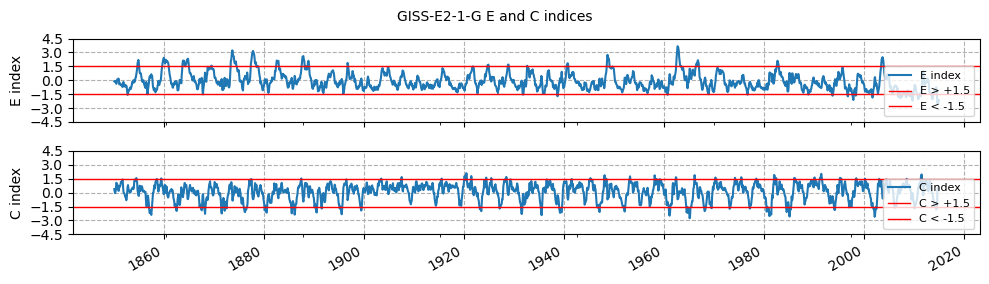

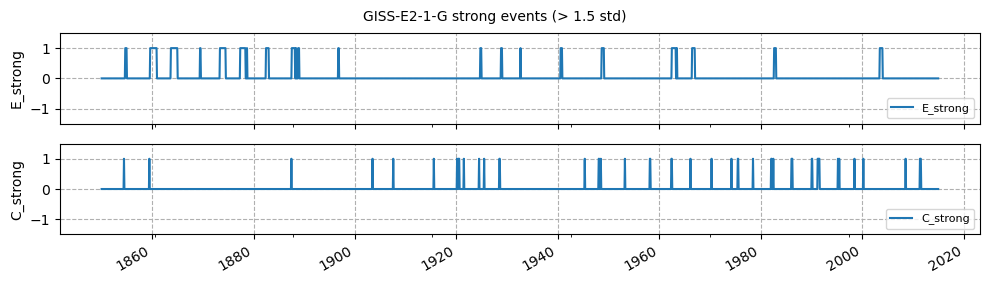

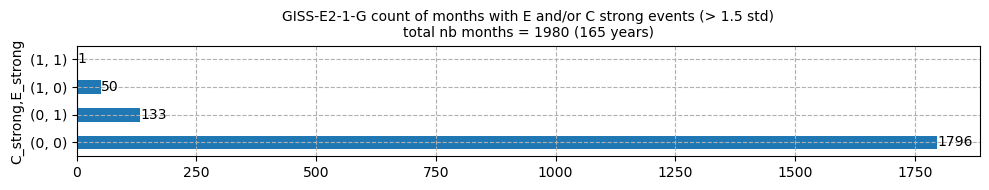

Number of months with E strong events (E > 1.5): 134/1980 (6.77%)
Number of months with C strong events (C > 1.5):  51/1980 (2.58%)







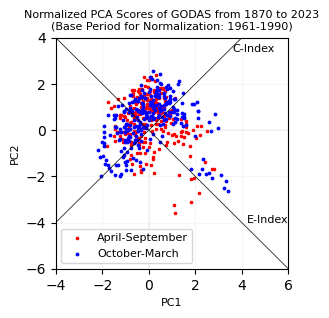

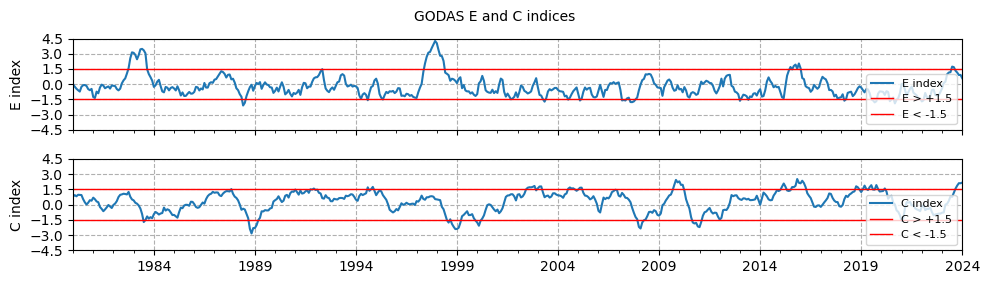

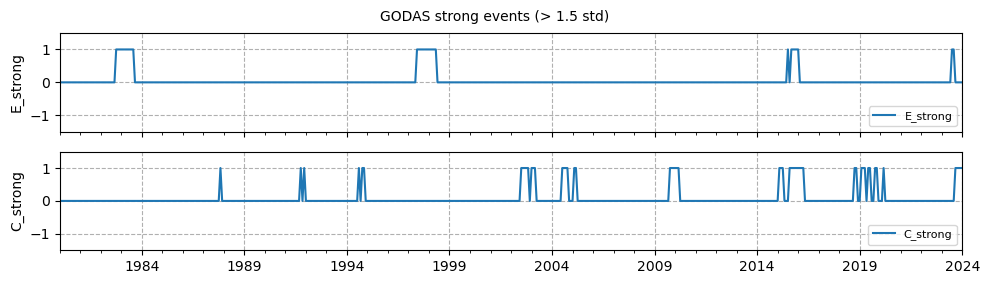

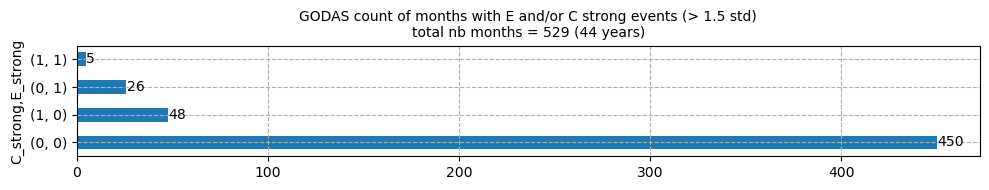

Number of months with E strong events (E > 1.5):  31/529 (5.86%)
Number of months with C strong events (C > 1.5):  53/529 (10.02%)







In [55]:

for source_id, pca_ec_indices in pca_ec_indices_dict.items():
    
    ########## Plot Normalized Monthly PCA Scores ########## 
    plt.figure(figsize=(3, 3))
    
    # April–September: red crosses
    pca_scores_apr_sep = pca_ec_indices_dict[source_id][~pca_ec_indices_dict[source_id].index.month.isin([10, 11, 12, 1, 2, 3])]
    plt.scatter(pca_scores_apr_sep['PC1'], pca_scores_apr_sep['PC2'], color='red', marker='x', s=3, label='April-September')
    
    # October–March: blue circles
    pca_scores_oct_mar = pca_ec_indices_dict[source_id][pca_ec_indices_dict[source_id].index.month.isin([10, 11, 12, 1, 2, 3])]
    plt.scatter(pca_scores_oct_mar['PC1'], pca_scores_oct_mar['PC2'], color='blue', marker='o', s=3, label='October-March')
            
    # PC1 and PC2 axes 
    plt.axhline(y=0, color='grey', linewidth=0.1)
    plt.axvline(x=0, color='grey', linewidth=0.1)
    
    # C-Index line 
    plt.axline((0, 0), slope=1., color='black', linewidth=0.5)
    
    # E-Index line
    plt.axline((0, 0), slope=-1., color='black', linewidth=0.5)
    
    # Add labels to the lines
    plt.annotate('C-Index', xy=(3.6, 3.4), fontsize=8, color='black')
    plt.annotate('E-Index', xy=(4.2, -4), fontsize=8, color='black')
    
    # Set plot labels and title
    plt.xlabel('PC1', fontsize=8)
    plt.xlim(-4,6)
    plt.ylabel('PC2', fontsize=8)
    plt.ylim(-6,4)
    plt.legend(fontsize=8, loc="lower left")
    plt.title(f'Normalized PCA Scores of {source_id} from {start_year} to {end_year}\n(Base Period for Normalization: {BASE_PERIOD_START_yr}-{BASE_PERIOD_END_yr})', fontsize=8)
    plt.grid(alpha=0.1)
    plt.show()


    ########## Plot E and C indices time series ########## 
    fig, axs = plt.subplots(nrows=2, figsize=(10, 3), sharex=True)
    for ax, column in zip(axs, ['E', 'C']):
        pca_ec_indices_dict[source_id].loc[:, column].plot(ax=ax, label=f"{column} index")
        ax.axhline(y=-1.5, color='red', linewidth=1, label=f"{column} > +1.5")
        ax.axhline(y=1.5, color='red', linewidth=1, label=f"{column} < -1.5")
        ax.set_ylabel(f"{column} index")
        ax.set_ylim(-4.5, 4.5) 
        ax.set_yticks(np.arange(-4.5, 6, 1.5))
        ax.grid(linestyle='--')
        ax.legend(loc='lower right', fontsize=8)
    plt.suptitle(f"{source_id} E and C indices", fontsize=10, y=0.93)
    plt.tight_layout()
    plt.show()

    counts = {}
    
    ########## Plot E and C strong events time series ########## 
    fig, axs = plt.subplots(nrows=2, figsize=(10, 3), sharex=True)
    for ax, column in zip(axs, ['E_strong', 'C_strong']):        
        pca_ec_indices_dict[source_id].loc[:, column].plot(ax=ax, label=f"{column}")
        counts[column] = pca_ec_indices_dict[source_id].loc[:, column].sum()
        ax.set_ylabel(f"{column}")
        ax.set_ylim(-1.5, 1.5) 
        ax.grid(linestyle='--')
        ax.legend(loc='lower right', fontsize=8)    
    plt.suptitle(f"{source_id} strong events (> 1.5 std)", fontsize=10, y=0.93)
    plt.tight_layout()
    plt.show()


    total_time_steps = pca_ec_indices_dict[source_id].shape[0]


    ########## Bar plot with counts of strong events ########## 
    value_counts = pca_ec_indices_dict[source_id][['C_strong', 'E_strong']].value_counts()
    # print(value_counts)
    plt.figure(figsize=(10, 2))
    bar_plot = value_counts.plot(kind="barh")
    plt.xticks(rotation=0)
    plt.grid(linestyle='--')
    # Adding values to the right of the bars
    for bar, value_count in zip(bar_plot.patches, value_counts):
        plt.text(bar.get_width() + 0.1,  # x-coordinate position
                 bar.get_y() + bar.get_height() / 2,  # y-coordinate position
                 f'{value_count}',  # text to display
                 va='center')  # vertical alignment
    plt.title(f"{source_id} count of months with E and/or C strong events (> 1.5 std)\ntotal nb months = {total_time_steps} ({total_time_steps//12} years)", fontsize=10)
    plt.tight_layout()
    plt.show()
    

    print(f'Number of months with E strong events (E > 1.5): {counts['E_strong']:>3}/{total_time_steps} ({counts['E_strong']/total_time_steps:.2%})')
    print(f'Number of months with C strong events (C > 1.5): {counts['C_strong']:>3}/{total_time_steps} ({counts['C_strong']/total_time_steps:.2%})')

    print("\n\n=============================================================================================================\n\n\n")